In [1]:
import numpy as np
import math
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import tikzplotlib as tkz
import warnings
warnings.filterwarnings("ignore")

import os, sys

_, filename = os.path.split(os.getcwd())
if filename == 'notebooks':
    old_dir = os.getcwd()
    os.chdir('../')
    print('Moving Current Directory from ' + old_dir + ' to ' + os.getcwd())
else:
    print('Current Directory is ' + os.getcwd())

sys.path.append('./')  

from FRB.agents import UCB1Agent, FactoredUCBAgent, TMRobustUCBAgent #, FactoredUCBAgentMM
from FRB.env import FactoredEnv
from FRB.utils import get_pulled_expected, compute_max_expected, create_action_matrix, get_sigma_square_eq_max

Moving Current Directory from /home/simone/Projects/research/FRB/notebooks to /home/simone/Projects/research/FRB


In [2]:
class FactoredUCBAgentMM():
    """
    This class implements the FRB MM optimal algorithm in its anytime
    version for bounded variables
    """
    def __init__(self, k, d, time_horizon, sigma=0.5,
                 max_reward=1, exploration_alpha=4, bounded=True):
        self.k = k
        self.d = d
        self.T = time_horizon
        self.max_reward = max_reward
        if bounded:
            self.sigma = sigma
        else:
            self.sigma2 = (1 + sigma**2)**d
            self.sigma = np.sqrt(self.sigma2)
        self.exploration_alpha = exploration_alpha
        self.num_actions = self.k ** self.d
        self.bounded = bounded
        # Creation of the action matrix
        self.action_matrix = np.zeros(
            (self.num_actions, self.d), dtype=int
        )
        for i in range(self.d):
            vect = -1 * np.ones(self.k**(i+1))
            external_repeats = int(self.k**(self.d-(i+1)))
            internal_repeats = self.k**i
            for j in range(self.k):
                vect[j*internal_repeats:(j+1)*internal_repeats] = j
            vect_new = np.copy(vect).reshape(-1, 1)
            for _ in range(external_repeats-1):
                vect_new = np.vstack((vect_new, vect.reshape(-1, 1)))
            self.action_matrix[:, i] = vect_new.ravel()
        self.reset()

    def reset(self):
        self.t = 1
        self.last_pull = None
        self.n_min_pull = np.zeros(self.num_actions, dtype=int)
        self.n_pulls = np.zeros((self.d, self.k), dtype=int)
        self.observations = -1 * np.ones((self.d, self.k, self.T), dtype=int)
        self.virtual_pulls_sum = np.zeros(self.num_actions)

    def pull_arm(self):
        # if self.bounded:
        #     for i in range(self.num_actions):
        #         action_vector = self.action_matrix[i, :]
        #         new_min_pull = self.n_pulls[0, action_vector[0]]
        #         for j in range(1, self.d):
        #             new_min_pull = min(new_min_pull, self.n_pulls[j, action_vector[j]])
        #         if new_min_pull != self.n_min_pull[i]:
        #             self.n_min_pull[i] = new_min_pull
        #             aux = 1
        #             for j in range(self.d):
        #                 aux *= self.observations[j, self.last_pull[j], self.n_min_pull[i]-1]
        #             self.virtual_pulls_sum[i] += aux
        #     mean = self.virtual_pulls_sum / self.n_min_pull
        #     ucb = mean + self.sigma * np.sqrt(self.exploration_alpha * math.log(self.t) / self.n_min_pull)

        # else:
        #     for i in range(self.num_actions):
        #         action_vector = self.action_matrix[i, :]
        #         new_min_pull = self.n_pulls[0, action_vector[0]]
        #         for j in range(1, self.d):
        #             new_min_pull = min(new_min_pull, self.n_pulls[j, action_vector[j]])
        #         if new_min_pull != self.n_min_pull[i]:
        #             self.n_min_pull[i] = new_min_pull

        #             if self.last_pull is not None and (action_vector == self.last_pull).any() and self.n_min_pull[i]>0:
        #                 _observations = np.zeros((self.d, self.n_min_pull[i]-1))
        #                 for h in range(self.d):
        #                     _observations[h, :] = self.observations[h,action_vector[h],:self.n_min_pull[i]-1]
        #                 x = np.prod(_observations, axis = 0)
        #                 # self.virtual_pulls_sum[i] = self.trimmed_mean(x, self.sigma, 1/self.T, 1)
        #                 self.virtual_pulls_sum[i] = np.mean(np.where(np.abs(x)<= self.threshold_lookup(self.t, 1),
        #                                           x, 0))
                    
        #     mean = self.virtual_pulls_sum
        #     ucb = mean + self.sigma * np.sqrt(4*self.exploration_alpha * math.log(self.t**2) / self.n_min_pull)

        if self.bounded:
            pass
        else:
            for i in range(self.num_actions):
                action_vector = self.action_matrix[i, :]
                # Check if any element of action_vector has been pulled
                if self.last_pull is not None and (action_vector == self.last_pull).any():
                    # Check if the equivalent number of pulls of action_vector changes
                    new_min_pull = self.n_pulls[0, action_vector[0]]
                    for j in range(1, self.d):
                        new_min_pull = min(new_min_pull, self.n_pulls[j, action_vector[j]])
                    
                    if new_min_pull > self.n_min_pull[i]:
                        self.n_min_pull[i] = new_min_pull
                        # Update estimated mean
                        _observations = np.zeros((self.d, self.n_min_pull[i]))
                    
                        for h in range(self.d):
                            _observations[h, :] = self.observations[h,action_vector[h],:self.n_min_pull[i]]
                        
                        x = np.prod(_observations, axis = 0)
                        # self.virtual_pulls_sum[i] = self.trimmed_mean(x, self.sigma, 1/self.T, 1)
                        self.virtual_pulls_sum[i] = np.mean(np.where(np.abs(x) <= self.threshold_lookup(self.t, 1), x, 0))
            
            mean = self.virtual_pulls_sum
            # ucb = mean + self.sigma * np.sqrt(2 * self.exploration_alpha * math.log(self.t) / self.n_min_pull)

            ucb = mean + 4*self.sigma2**(1/2) * (2*np.log(self.t)/self.n_min_pull)**(1/2)


            
        self.last_pull = self.action_matrix[int(np.argmax(ucb)), :]
        return self.last_pull

    def update(self, observations):
        self.t += 1
        for i in range(self.d):
            self.observations[i, self.last_pull[i], self.n_pulls[i, self.last_pull[i]]] = observations[i]
            self.n_pulls[i, self.last_pull[i]] = self.n_pulls[i, self.last_pull[i]] + 1

    def threshold_lookup(self, n, epsilon):
        return (self.sigma2*n/np.log(n**-2))**(1/(1+epsilon))
    
    def trimmed_mean(self, x, u, delta, epsilon):
        n = x.shape[0]
        mask = np.zeros(x.shape)
        _log = np.log(1/delta)
        
        t = np.arange(n)
        mask = np.abs(x) <= (u*t - _log)**(1/(1+epsilon))
        
        mask = np.array(mask, dtype='bool')

        mu = np.sum(x[mask]) / n
        return mu

  0%|          | 0/4 [00:00<?, ?it/s]

\JPAalgnameshort run completed - k=2 d=1 $\sigma$=0.1
T=1000: $1.73 \ (0.45)$
T=2000: $2.1 \ (0.62)$
T=5000: $2.34 \ (0.64)$


  0%|          | 0/4 [00:00<?, ?it/s]

\JPAalgnameshortMM run completed - k=2 d=1 $\sigma$=0.1
T=1000: $90.75 \ (18.29)$
T=2000: $181.49 \ (36.58)$
T=5000: $453.73 \ (91.45)$


  0%|          | 0/4 [00:00<?, ?it/s]

\ucbone run completed - k=2 d=1 $\sigma$=0.1
T=1000: $1.73 \ (0.45)$
T=2000: $2.1 \ (0.62)$
T=5000: $2.34 \ (0.64)$


  0%|          | 0/4 [00:00<?, ?it/s]

\httem run completed - k=2 d=1 $\sigma$=0.1
T=1000: $90.75 \ (18.29)$
T=2000: $181.49 \ (36.58)$
T=5000: $453.73 \ (91.45)$


  0%|          | 0/4 [00:00<?, ?it/s]

\JPAalgnameshort run completed - k=3 d=1 $\sigma$=0.1
T=1000: $3.11 \ (0.92)$
T=2000: $3.96 \ (0.72)$
T=5000: $4.29 \ (0.87)$


  0%|          | 0/4 [00:00<?, ?it/s]

\JPAalgnameshortMM run completed - k=3 d=1 $\sigma$=0.1
T=1000: $146.65 \ (30.93)$
T=2000: $293.26 \ (61.84)$
T=5000: $733.27 \ (154.65)$


  0%|          | 0/4 [00:00<?, ?it/s]

\ucbone run completed - k=3 d=1 $\sigma$=0.1
T=1000: $3.11 \ (0.92)$
T=2000: $3.96 \ (0.72)$
T=5000: $4.29 \ (0.87)$


  0%|          | 0/4 [00:00<?, ?it/s]

\httem run completed - k=3 d=1 $\sigma$=0.1
T=1000: $146.59 \ (30.9)$
T=2000: $293.39 \ (61.91)$
T=5000: $733.3 \ (154.65)$


  0%|          | 0/4 [00:00<?, ?it/s]

\JPAalgnameshort run completed - k=2 d=2 $\sigma$=0.1
T=1000: $3.34 \ (0.69)$
T=2000: $4.18 \ (0.95)$
T=5000: $4.89 \ (1.18)$


  0%|          | 0/4 [00:00<?, ?it/s]

\JPAalgnameshortMM run completed - k=2 d=2 $\sigma$=0.1
T=1000: $103.85 \ (15.71)$
T=2000: $207.66 \ (31.42)$
T=5000: $519.09 \ (78.56)$


  0%|          | 0/4 [00:00<?, ?it/s]

\ucbone run completed - k=2 d=2 $\sigma$=0.1
T=1000: $5.73 \ (0.55)$
T=2000: $6.76 \ (0.72)$
T=5000: $8.17 \ (1.0)$


  0%|          | 0/4 [00:00<?, ?it/s]

\httem run completed - k=2 d=2 $\sigma$=0.1
T=1000: $98.8 \ (13.59)$
T=2000: $197.61 \ (27.18)$
T=5000: $494.01 \ (67.96)$


  0%|          | 0/4 [00:00<?, ?it/s]

\JPAalgnameshort run completed - k=3 d=2 $\sigma$=0.1
T=1000: $5.34 \ (0.7)$
T=2000: $6.8 \ (0.94)$
T=5000: $8.35 \ (1.04)$


  0%|          | 0/4 [00:00<?, ?it/s]

\JPAalgnameshortMM run completed - k=3 d=2 $\sigma$=0.1
T=1000: $141.99 \ (22.14)$
T=2000: $283.94 \ (44.21)$
T=5000: $709.8 \ (110.42)$


  0%|          | 0/4 [00:00<?, ?it/s]

\ucbone run completed - k=3 d=2 $\sigma$=0.1
T=1000: $19.97 \ (11.1)$
T=2000: $34.17 \ (21.45)$
T=5000: $74.33 \ (54.06)$


  0%|          | 0/4 [00:00<?, ?it/s]

\httem run completed - k=3 d=2 $\sigma$=0.1
T=1000: $119.86 \ (8.72)$
T=2000: $239.81 \ (17.5)$
T=5000: $599.75 \ (43.71)$


  0%|          | 0/4 [00:00<?, ?it/s]

\JPAalgnameshort run completed - k=2 d=3 $\sigma$=0.1
T=1000: $2.93 \ (0.63)$
T=2000: $3.75 \ (0.71)$
T=5000: $4.69 \ (1.05)$


  0%|          | 0/4 [00:00<?, ?it/s]

\JPAalgnameshortMM run completed - k=2 d=3 $\sigma$=0.1
T=1000: $86.9 \ (11.86)$
T=2000: $173.78 \ (23.71)$
T=5000: $434.4 \ (59.21)$


  0%|          | 0/4 [00:00<?, ?it/s]

\ucbone run completed - k=2 d=3 $\sigma$=0.1
T=1000: $38.76 \ (13.94)$
T=2000: $70.79 \ (28.72)$
T=5000: $158.76 \ (72.57)$


  0%|          | 0/4 [00:00<?, ?it/s]

\httem run completed - k=2 d=3 $\sigma$=0.1
T=1000: $84.26 \ (10.48)$
T=2000: $168.55 \ (21.03)$
T=5000: $421.46 \ (52.57)$


  0%|          | 0/4 [00:00<?, ?it/s]

\JPAalgnameshort run completed - k=3 d=3 $\sigma$=0.1
T=1000: $5.27 \ (0.73)$
T=2000: $6.17 \ (0.86)$
T=5000: $7.8 \ (1.08)$


  0%|          | 0/4 [00:00<?, ?it/s]

\JPAalgnameshortMM run completed - k=3 d=3 $\sigma$=0.1
T=1000: $153.73 \ (25.81)$
T=2000: $307.3 \ (51.58)$
T=5000: $768.19 \ (128.92)$


  0%|          | 0/4 [00:00<?, ?it/s]

\ucbone run completed - k=3 d=3 $\sigma$=0.1
T=1000: $73.66 \ (9.02)$
T=2000: $136.35 \ (18.2)$
T=5000: $315.36 \ (46.12)$


  0%|          | 0/4 [00:00<?, ?it/s]

\httem run completed - k=3 d=3 $\sigma$=0.1
T=1000: $130.01 \ (20.28)$
T=2000: $260.01 \ (40.6)$
T=5000: $650.07 \ (101.42)$


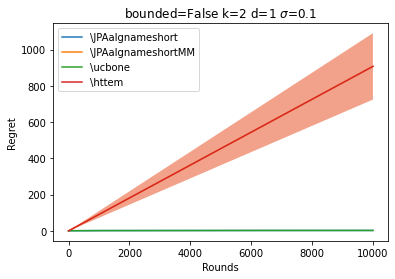

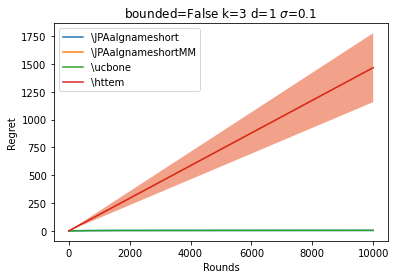

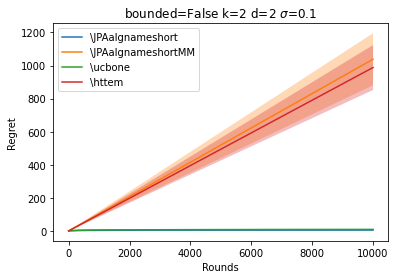

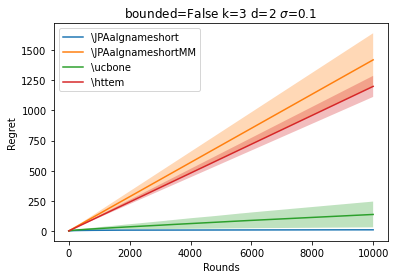

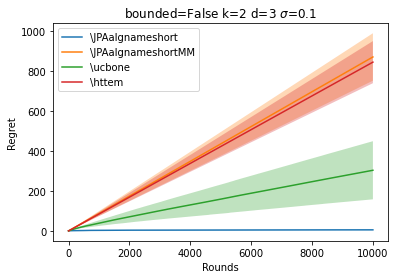

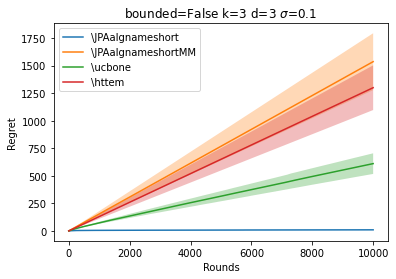

In [3]:
# BASIC SETTING FOR EXPERIMENTS
fucb = '\\JPAalgnameshort'
fucbMM = '\\JPAalgnameshortMM'
ucbone = '\\ucbone'
httem = '\\httem'
algs = [fucb, fucbMM, ucbone, httem]
# T = 10000
# checkpoints = [1000, 5000, 10000]
# n_trials = 50
# seed = 0
# k_list = [3, 5]
# d_list = [1, 2, 3, 4]
# bounded_list = [True, False]   
# do_subsampling = True

# OVERRIDE FOR TESTING PURPOSE TO SPEED UP THE RUNS
T = 10000
checkpoints = [1000, 2000, 5000]
bounded_list = [False] 
algs = [fucb, fucbMM, ucbone, httem]
n_trials = 4
k_list = [2, 3]
d_list = [1, 2, 3]
do_subsampling = False
    
result_table = {}

for bounded in bounded_list:

    result_table[bounded] = {}
    
    if bounded: 
        sigma = 0.5 # fixed for bernoulli
    else:
        sigma = 0.1
    
    for d in d_list:

        result_table[bounded][d] = {}

        for k in k_list:

            result_table[bounded][d][k] = {}

            arms_vect = k * np.ones(d, dtype=int)

            # F-UCB INIT
            agent_factored = FactoredUCBAgent(arms_vect, d, sigma)

            # F-UCB-MM INIT
            agent_factored_MM = FactoredUCBAgentMM(k, d, T, sigma=sigma, bounded=bounded)
            
            # UCB1 INIT
            agent_ucb = UCB1Agent(d*k, sigma)
            action_mx = create_action_matrix(d, k)

            # HT-TEM INIT
            agent_ht_tem = TMRobustUCBAgent(d*k, 1, (1+sigma**2)**d)
            
            mean_cum_expected_regret = {}
            std_cum_expected_regret = {}
            
            for alg in algs:

                result_table[bounded][d][k][alg] = {}

                env = FactoredEnv(arms_vect, d, sigma=sigma, bounded=bounded)

                inst_expected_regret = np.zeros((n_trials, T))
                
                # for trial_i in range(n_trials):
                for trial_i in tqdm(range(n_trials)):
                
                    vals_expected = env.get_expected()
                    max_expected = compute_max_expected(vals_expected)

                    for t in range(T):

                        if alg == ucbone:
                            action = action_mx[agent_ucb.pull_arm(), :]
                            agent_ucb.update(np.prod(env.step(action)))
                        elif alg == fucb:
                            action = agent_factored.pull_arm()
                            agent_factored.update(env.step(action))
                        elif alg == fucbMM:
                            action = agent_factored_MM.pull_arm()
                            agent_factored_MM.update(env.step(action))
                        elif alg == httem:
                            action = action_mx[agent_ht_tem.pull_arm(), :]
                            agent_ht_tem.update(np.prod(env.step(action)))
                        else:
                            raise ValueError('Error in selecting algorithm')

                        inst_expected_regret[trial_i, t] = max_expected - get_pulled_expected(
                            vals_expected, action)
                    
                    # I reset all the agents, becuase i do not know which one 
                    # i am using for the sake of simplicity
                    agent_ucb.reset()
                    agent_factored.reset()
                    agent_factored_MM.reset()
                    agent_ht_tem.reset()
                    
                    if trial_i < n_trials - 1:
                        env.reset()
                
                # maybe replace with cumsum with correct axis
                cum_expected_regret = np.zeros(inst_expected_regret.shape)
                cum_expected_regret[:, 0] = inst_expected_regret[:, 0]
                for i in range(1, T):
                    cum_expected_regret[:, i] = inst_expected_regret[:, i] + cum_expected_regret[:, i-1]

                mean_cum_expected_regret[alg] = np.mean(cum_expected_regret, axis=0)
                std_cum_expected_regret[alg] = np.std(cum_expected_regret, axis=0) / np.sqrt(n_trials)

                print('{} run completed - k={} d={} $\sigma$={}'.format(alg, k, d, sigma))
                for i in checkpoints:
                    result_table[bounded][d][k][alg][i] = '${} \ ({})$   '.format(
                        round(mean_cum_expected_regret[alg][i-1], 2), 
                        round(std_cum_expected_regret[alg][i-1], 2)
                    )
                    print('T={}: ${} \ ({})$'.format(i, round(mean_cum_expected_regret[alg][i-1], 2), 
                                                  round(std_cum_expected_regret[alg][i-1], 2)))

            plt.figure()
            if do_subsampling:
                subsample = 50
                assert T % subsample == 0
                x_plt = np.linspace(0, T-1, int(T/subsample), dtype=int)
            else:
                x_plt = np.linspace(0, T-1, T, dtype=int)
            for alg in algs:
                plt.plot(x_plt, mean_cum_expected_regret[alg][x_plt], 
                         label=alg)
                plt.fill_between(x_plt, 
                                 mean_cum_expected_regret[alg][x_plt] - std_cum_expected_regret[alg][x_plt], 
                                 mean_cum_expected_regret[alg][x_plt] + std_cum_expected_regret[alg][x_plt], 
                                 alpha=0.3)
            plt.legend()
            plt.xlabel('Rounds')
            plt.ylabel('Regret')
            plt.title('bounded={} k={} d={} $\sigma$={}'.format(bounded, k, d, sigma))
            if bounded:
                save_str = 'results/bounded_k{}_d{}'.format(k, d)
            else:
                save_str = 'results/subgauss_k{}_d{}'.format(k, d)
            plt.savefig(save_str + '.png')
            tkz.save(save_str + '.tex')

In [4]:
print('d= \t k= \t T=\t\t', end='')
[print(alg, end='\t\t\t') for alg in algs]
print('')

for d in d_list:
    for k in k_list:
        for T_val in checkpoints:
            print('${}$ & \t ${}$ & \t ${}$ \t\t'.format(d, k, T_val), end='')
            for bounded in bounded_list:
                for alg in algs:
                    print('&', result_table[bounded][d][k][alg][T_val], end='\t')
            if T_val == checkpoints[-1]:
                print('\\\\\n\\cmidrule{2-10}')
            else:
                print('\\\\\n\\cmidrule{3-10}')
    print('\cmidrule{1-10}')

d= 	 k= 	 T=		\JPAalgnameshort			\JPAalgnameshortMM			\ucbone			\httem			
$1$ & 	 $2$ & 	 $1000$ 		& $1.73 \ (0.45)$   	& $90.75 \ (18.29)$   	& $1.73 \ (0.45)$   	& $90.75 \ (18.29)$   	\\
\cmidrule{3-10}
$1$ & 	 $2$ & 	 $2000$ 		& $2.1 \ (0.62)$   	& $181.49 \ (36.58)$   	& $2.1 \ (0.62)$   	& $181.49 \ (36.58)$   	\\
\cmidrule{3-10}
$1$ & 	 $2$ & 	 $5000$ 		& $2.34 \ (0.64)$   	& $453.73 \ (91.45)$   	& $2.34 \ (0.64)$   	& $453.73 \ (91.45)$   	\\
\cmidrule{2-10}
$1$ & 	 $3$ & 	 $1000$ 		& $3.11 \ (0.92)$   	& $146.65 \ (30.93)$   	& $3.11 \ (0.92)$   	& $146.59 \ (30.9)$   	\\
\cmidrule{3-10}
$1$ & 	 $3$ & 	 $2000$ 		& $3.96 \ (0.72)$   	& $293.26 \ (61.84)$   	& $3.96 \ (0.72)$   	& $293.39 \ (61.91)$   	\\
\cmidrule{3-10}
$1$ & 	 $3$ & 	 $5000$ 		& $4.29 \ (0.87)$   	& $733.27 \ (154.65)$   	& $4.29 \ (0.87)$   	& $733.3 \ (154.65)$   	\\
\cmidrule{2-10}
\cmidrule{1-10}
$2$ & 	 $2$ & 	 $1000$ 		& $3.34 \ (0.69)$   	& $103.85 \ (15.71)$   	& $5.73 \ (0.55)$   	& $98.8 \ (13.59)$ 

d= 	 k= 	 T=		\JPAalgnameshort			\JPAalgnameshortMM			\ucbone			\httem			
$1$ & 	 $3$ & 	 $1000$ 		& $25.61 \ (1.0)$   	& $25.6 \ (1.01)$   	& $25.61 \ (1.0)$   	& $117.94 \ (6.28)$   	& $2.72 \ (0.2)$   	& $107.35 \ (10.14)$   	& $2.72 \ (0.2)$   	& $116.96 \ (6.26)$   	\\
\cmidrule{3-10}
$1$ & 	 $3$ & 	 $5000$ 		& $51.25 \ (2.6)$   	& $51.35 \ (2.59)$   	& $51.25 \ (2.6)$   	& $377.0 \ (14.51)$   	& $4.44 \ (0.47)$   	& $394.77 \ (47.56)$   	& $4.44 \ (0.47)$   	& $376.82 \ (14.58)$   	\\
\cmidrule{3-10}
$1$ & 	 $3$ & 	 $10000$ 		& $65.3 \ (3.9)$   	& $65.19 \ (3.91)$   	& $65.3 \ (3.9)$   	& $575.0 \ (18.42)$   	& $5.52 \ (0.67)$   	& $679.17 \ (90.19)$   	& $5.52 \ (0.67)$   	& $575.02 \ (18.17)$   	\\
\cmidrule{2-10}
$1$ & 	 $5$ & 	 $1000$ 		& $46.67 \ (1.01)$   	& $46.77 \ (0.97)$   	& $46.67 \ (1.01)$   	& $178.52 \ (6.84)$   	& $5.18 \ (0.22)$   	& $143.37 \ (11.4)$   	& $5.18 \ (0.22)$   	& $178.26 \ (6.87)$   	\\
\cmidrule{3-10}
$1$ & 	 $5$ & 	 $5000$ 		& $93.23 \ (2.83)$   	& $93.05 \ (2.95)$   	& $93.23 \ (2.83)$   	& $640.81 \ (21.79)$   	& $7.73 \ (0.52)$   	& $492.95 \ (58.95)$   	& $7.73 \ (0.52)$   	& $640.03 \ (21.48)$   	\\
\cmidrule{3-10}
$1$ & 	 $5$ & 	 $10000$ 		& $118.27 \ (4.42)$   	& $117.8 \ (4.52)$   	& $118.27 \ (4.42)$   	& $1013.28 \ (29.75)$   	& $9.16 \ (0.7)$   	& $826.64 \ (116.34)$   	& $9.16 \ (0.7)$   	& $1016.67 \ (29.11)$   	\\
\cmidrule{2-10}
\cmidrule{1-10}
$2$ & 	 $3$ & 	 $1000$ 		& $44.65 \ (1.24)$   	& $127.48 \ (14.51)$   	& $99.05 \ (11.05)$   	& $218.0 \ (11.02)$   	& $4.67 \ (0.2)$   	& $267.74 \ (14.63)$   	& $42.19 \ (10.99)$   	& $219.14 \ (11.05)$   	\\
\cmidrule{3-10}
$2$ & 	 $3$ & 	 $5000$ 		& $87.24 \ (2.66)$   	& $512.17 \ (69.49)$   	& $300.46 \ (56.14)$   	& $880.79 \ (48.54)$   	& $7.14 \ (0.48)$   	& $1339.73 \ (71.42)$   	& $186.56 \ (54.39)$   	& $884.31 \ (48.42)$   	\\
\cmidrule{3-10}
$2$ & 	 $3$ & 	 $10000$ 		& $111.55 \ (4.17)$   	& $969.79 \ (138.09)$   	& $510.31 \ (111.08)$   	& $1518.28 \ (97.52)$   	& $8.41 \ (0.66)$   	& $2683.38 \ (142.41)$   	& $364.8 \ (108.53)$   	& $1524.1 \ (97.12)$   	\\
\cmidrule{2-10}
$2$ & 	 $5$ & 	 $1000$ 		& $83.73 \ (1.81)$   	& $162.88 \ (13.63)$   	& $172.01 \ (15.05)$   	& $308.8 \ (14.12)$   	& $9.38 \ (0.35)$   	& $353.87 \ (15.53)$   	& $87.39 \ (15.22)$   	& $309.58 \ (14.15)$   	\\
\cmidrule{3-10}
$2$ & 	 $5$ & 	 $5000$ 		& $165.56 \ (4.05)$   	& $573.04 \ (65.84)$   	& $575.82 \ (77.56)$   	& $1353.7 \ (68.88)$   	& $14.1 \ (0.71)$   	& $1785.66 \ (74.72)$   	& $396.13 \ (75.5)$   	& $1355.17 \ (68.83)$   	\\
\cmidrule{3-10}
$2$ & 	 $5$ & 	 $10000$ 		& $213.49 \ (6.58)$   	& $1046.43 \ (129.32)$   	& $1016.49 \ (154.19)$   	& $2447.43 \ (139.31)$   	& $16.89 \ (0.98)$   	& $3576.17 \ (148.54)$   	& $778.71 \ (150.81)$   	& $2448.84 \ (139.1)$   	\\
\cmidrule{2-10}
\cmidrule{1-10}
$3$ & 	 $3$ & 	 $1000$ 		& $51.66 \ (1.88)$   	& $142.14 \ (13.23)$   	& $210.43 \ (19.01)$   	& $277.61 \ (19.71)$   	& $5.43 \ (0.24)$   	& $294.03 \ (17.07)$   	& $148.88 \ (18.9)$   	& $277.12 \ (19.72)$   	\\
\cmidrule{3-10}
$3$ & 	 $3$ & 	 $5000$ 		& $103.67 \ (3.89)$   	& $534.71 \ (67.04)$   	& $880.13 \ (95.1)$   	& $1300.12 \ (95.92)$   	& $8.49 \ (0.48)$   	& $1476.91 \ (85.48)$   	& $699.71 \ (94.05)$   	& $1299.32 \ (96.16)$   	\\
\cmidrule{3-10}
$3$ & 	 $3$ & 	 $10000$ 		& $130.95 \ (5.37)$   	& $955.86 \ (123.77)$   	& $1641.97 \ (190.3)$   	& $2483.36 \ (190.2)$   	& $10.17 \ (0.75)$   	& $2964.56 \ (171.11)$   	& $1381.59 \ (187.85)$   	& $2478.67 \ (190.41)$   	\\
\cmidrule{2-10}
$3$ & 	 $5$ & 	 $1000$ 		& $104.88 \ (2.49)$   	& $248.56 \ (15.53)$   	& $328.22 \ (19.28)$   	& $396.65 \ (17.87)$   	& $11.98 \ (0.45)$   	& $413.05 \ (18.36)$   	& $235.9 \ (21.03)$   	& $397.0 \ (17.84)$   	\\
\cmidrule{3-10}
$3$ & 	 $5$ & 	 $5000$ 		& $214.88 \ (5.2)$   	& $810.9 \ (75.49)$   	& $1385.42 \ (104.27)$   	& $1901.5 \ (90.04)$   	& $18.36 \ (0.92)$   	& $2067.63 \ (91.3)$   	& $1110.88 \ (104.76)$   	& $1902.34 \ (89.67)$   	\\
\cmidrule{3-10}
$3$ & 	 $5$ & 	 $10000$ 		& $274.16 \ (7.57)$   	& $1395.04 \ (147.59)$   	& $2586.55 \ (211.12)$   	& $3683.9 \ (182.26)$   	& $21.63 \ (1.14)$   	& $4139.21 \ (182.21)$   	& $2193.9 \ (209.1)$   	& $3684.07 \ (181.57)$   	\\
\cmidrule{2-10}
\cmidrule{1-10}
$4$ & 	 $3$ & 	 $1000$ 		& $54.1 \ (2.17)$   	& $173.18 \ (13.91)$   	& $231.93 \ (15.56)$   	& $272.18 \ (16.0)$   	& $6.13 \ (0.26)$   	& $279.87 \ (16.5)$   	& $171.85 \ (15.59)$   	& $272.43 \ (15.96)$   	\\
\cmidrule{3-10}
$4$ & 	 $3$ & 	 $5000$ 		& $109.61 \ (4.26)$   	& $627.08 \ (69.6)$   	& $1002.83 \ (79.82)$   	& $1318.72 \ (78.73)$   	& $9.58 \ (0.55)$   	& $1398.72 \ (82.36)$   	& $799.05 \ (77.62)$   	& $1318.71 \ (78.49)$   	\\
\cmidrule{3-10}
$4$ & 	 $3$ & 	 $10000$ 		& $141.67 \ (5.39)$   	& $1123.03 \ (139.34)$   	& $1886.23 \ (158.47)$   	& $2571.6 \ (156.35)$   	& $11.63 \ (0.75)$   	& $2797.29 \ (164.68)$   	& $1571.24 \ (154.96)$   	& $2571.89 \ (155.9)$   	\\
\cmidrule{2-10}
$4$ & 	 $5$ & 	 $1000$ 		& $117.6 \ (3.48)$   	& $316.29 \ (17.18)$   	& $381.58 \ (20.25)$   	& $413.28 \ (19.76)$   	& $13.74 \ (0.49)$   	& $427.8 \ (19.73)$   	& $306.4 \ (21.47)$   	& $413.14 \ (19.78)$   	\\
\cmidrule{3-10}
$4$ & 	 $5$ & 	 $5000$ 		& $247.53 \ (6.58)$   	& $1134.93 \ (87.45)$   	& $1741.2 \ (105.7)$   	& $2034.95 \ (99.14)$   	& $20.96 \ (0.88)$   	& $2138.68 \ (98.48)$   	& $1440.24 \ (106.57)$   	& $2034.1 \ (99.08)$   	\\
\cmidrule{3-10}
$4$ & 	 $5$ & 	 $10000$ 		& $318.79 \ (8.67)$   	& $1882.25 \ (158.54)$   	& $3319.16 \ (213.61)$   	& $4023.06 \ (199.04)$   	& $24.5 \ (1.12)$   	& $4277.27 \ (196.91)$   	& $2840.05 \ (212.48)$   	& $4021.3 \ (198.53)$   	\\
\cmidrule{2-10}
\cmidrule{1-10}